# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.077482,True,6.172711
1,0.416977,True,7.293069
2,-0.558168,True,4.378605
3,-0.179209,True,4.621983
4,-1.049729,True,1.828574
...,...,...,...
995,0.832911,False,1.897019
996,-0.132316,True,5.203305
997,1.735067,True,10.668257
998,0.671260,True,7.328378


<Axes: xlabel='v0'>

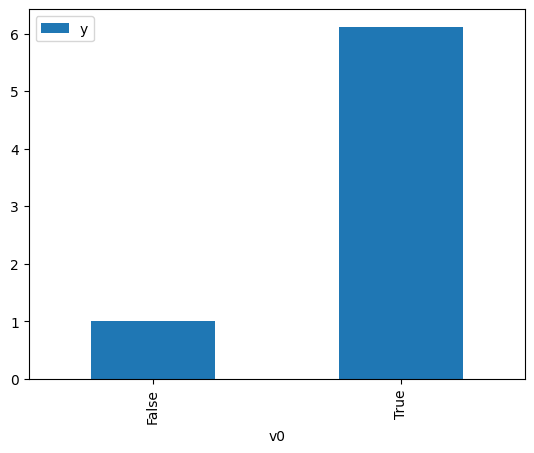

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

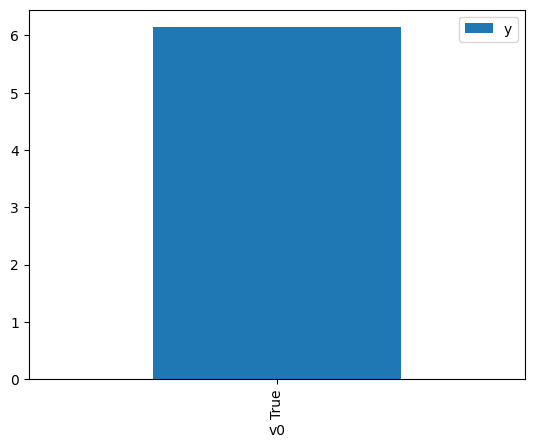

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.398889,False,0.042939,0.535400,1.867762
1,2.392600,False,5.868369,0.301696,3.314593
2,-0.813075,False,-0.817182,0.571360,1.750209
3,1.708041,False,3.548379,0.354654,2.819651
4,0.330070,False,0.862409,0.471442,2.121150
...,...,...,...,...,...
995,1.016531,False,2.207306,0.412022,2.427055
996,-0.194532,False,0.427513,0.517497,1.932378
997,1.064726,False,0.865518,0.407925,2.451432
998,1.004429,False,1.465809,0.413053,2.420998


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,2.001258,True,9.498883,0.668564,1.495744
1,-0.062604,True,5.517702,0.494088,2.023932
2,-0.718531,True,4.672812,0.436796,2.289399
3,0.174166,True,5.175002,0.514886,1.942176
4,0.998929,True,5.887404,0.586479,1.705092
...,...,...,...,...,...
995,0.737610,True,6.489730,0.564043,1.772915
996,-0.901059,True,3.321635,0.421084,2.374825
997,2.150581,True,7.866130,0.680088,1.470398
998,2.035276,True,9.295951,0.671208,1.489852


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.964
Model:                            OLS   Adj. R-squared (uncentered):              0.964
Method:                 Least Squares   F-statistic:                          1.349e+04
Date:                Mon, 15 Jan 2024   Prob (F-statistic):                        0.00
Time:                        08:29:35   Log-Likelihood:                         -1412.0
No. Observations:                1000   AIC:                                      2828.
Df Residuals:                     998   BIC:                                      2838.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.8526      0.030     61.035      0.000       1.793       1.912
x2             5.0446      0.048    104.530      0.000       4.950       5.139
==============================================================================
Omnibus:                        1.009   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.604   Jarque-Bera (JB):                1.050
Skew:                          -0.076   Prob(JB):                        0.592
Kurtosis:                       2.953   Cond. No.                         2.04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""